### We randomly sample 80% as training and 20% as testing.

In [1]:
import torch
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F # All functions that don't have any parameters
from torch.autograd import Variable

from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from quantile_forest import RandomForestQuantileRegressor


import cvxpy as cp
import numpy as np
from numpy import linalg
import pandas as pd

from scipy.linalg import sqrtm


from matplotlib import pyplot as plt

In [2]:
# Possible estimators

# 1-layer NN
class NN1(nn.Module):
    def __init__(self, input_size, output_size):
        super(NN1, self).__init__()
        self.fc1 = nn.Linear(input_size, 10)
        self.fc2 = nn.Linear(10, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# 2-layer NN
class NN2(nn.Module):
    def __init__(self, input_size, output_size):
        super(NN2, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x 
    
# Random Forest
# model setup: rf = RandomForestRegressor(n_estimators = 500, random_state = 18)
# training RF: rf.fit(X_pre, Y_pre)
# predict with RF: prediction = rf.predict(X_t)

# XGBoost
# model setup: xgb = XGBRegressor(n_estimators=300,random_state=0)
# training XGBoost: xgb.fit(X_pre,Y_pre)
#prediction with XGBoost: xgb.predict(X_t)


In [3]:
# train mean estimator that estimate E[Y|X]
def mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t):
    
    """
        est_type: 
        "NN1": 1-layer NN;    "NN2": 2-layer NN;    "rf": random forest; 
        "gb": gradient boosting;     "poly2": polynomial with degree 2
    
        (X_pre,Y_pre): training data
        X_opt,X_adj,X_t: data used to predict
        output: mean estimator m and the predictions m(X)
    """

    if est_type == "NN1":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = NN1(input_size=3, output_size=1).to(device)
        criterion=nn.MSELoss()
        learning_rate = 0.001
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        for epoch in range(1000):
            #convert numpy array to torch Variable
            inputs=Variable(torch.from_numpy(X_pre))
            labels=Variable(torch.from_numpy(Y_pre))
            
            #clear gradients wrt parameters
            optimizer.zero_grad()
    
            #Forward to get outputs
            outputs=model(inputs.float())
    
            #calculate loss
            loss=criterion(outputs.float(), labels.float())
    
            #getting gradients wrt parameters
            loss.backward()
    
            #updating parameters
            optimizer.step()
        M_opt = model(torch.from_numpy(X_opt).float())
        M_opt = M_opt.detach().cpu().numpy().reshape(-1,1)
        M_adj = model(torch.from_numpy(X_adj).float())
        M_adj = M_adj.detach().cpu().numpy().reshape(-1,1)
        M_t = model(torch.from_numpy(X_t).float())
        M_t = M_t.detach().cpu().numpy().reshape(-1,1)
        return model, M_opt, M_adj, M_t
    if est_type == "NN2":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = NN2(input_size=3, output_size=1).to(device)
        criterion=nn.MSELoss()
        learning_rate = 0.001
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        for epoch in range(1000):
            #convert numpy array to torch Variable
            inputs=Variable(torch.from_numpy(X_pre))
            labels=Variable(torch.from_numpy(Y_pre))
    
            #clear gradients wrt parameters
            optimizer.zero_grad()
    
            #Forward to get outputs
            outputs=model(inputs.float())
    
            #calculate loss
            loss=criterion(outputs.float(), labels.float())
    
            #getting gradients wrt parameters
            loss.backward()
    
            #updating parameters
            optimizer.step()
        M_opt = model(torch.from_numpy(X_opt).float())
        M_opt = M_opt.detach().cpu().numpy().reshape(-1,1)
        M_adj = model(torch.from_numpy(X_adj).float())
        M_adj = M_adj.detach().cpu().numpy().reshape(-1,1)
        M_t = model(torch.from_numpy(X_t).float())
        M_t = M_t.detach().cpu().numpy().reshape(-1,1)
        return model, M_opt, M_adj, M_t
    if est_type == "rf":
        model = RandomForestRegressor(n_estimators = 500, random_state = 0,criterion='squared_error')
        model.fit(X_pre, Y_pre)
        M_opt = model.predict(X_opt).reshape(-1,1)
        M_adj = model.predict(X_adj).reshape(-1,1)
        M_t = model.predict(X_t).reshape(-1,1)
        return model, M_opt, M_adj, M_t
    if est_type == "gb":
        model = GradientBoostingRegressor(n_estimators=300,random_state=0,loss = "squared_error")
        model.fit(X_pre, Y_pre)
        M_opt = model.predict(X_opt).reshape(-1,1)
        M_adj = model.predict(X_adj).reshape(-1,1)
        M_t = model.predict(X_t).reshape(-1,1)
        return model, M_opt, M_adj, M_t
    if est_type == "poly3":
        model = LinearRegression()
        poly_regr = PolynomialFeatures(degree = 3)
        X_pre_poly = poly_regr.fit_transform(X_pre) 
        model.fit(X_pre_poly, Y_pre)
        X_opt_poly = poly_regr.fit_transform(X_opt)
        X_adj_poly = poly_regr.fit_transform(X_adj) 
        X_t_poly = poly_regr.fit_transform(X_t)
        M_opt = model.predict(X_opt_poly).reshape(-1,1)
        M_adj = model.predict(X_adj_poly).reshape(-1,1)
        M_t = model.predict(X_t_poly).reshape(-1,1)
        return model, M_opt, M_adj, M_t

In [4]:
# train quantile estimator that estimate quantile for Y|X

# quantile loss for NN
def quantile_loss(preds, target, quantile):
    assert not target.requires_grad
    assert preds.size(0) == target.size(0)
    errors = target - preds
    q = quantile
    losses = torch.max((q - 1) * errors, q * errors)
    loss = torch.sum(losses)
    return loss

def est_quantile(est_type,quantile,X_pre,Y_pre,X_opt,X_adj,X_t):
    """
        est_type: 
        "NN1": 1-layer NN;              "NN2": 2-layer NN; 
        "qrf": quantile regression forest;    "gb": gradient boosting
        
        quantile: the quantile we are estimating
        (X_pre,Y_pre): training data
        X_opt,X_adj,X_t: data used to predict
        output: quantile estimator Q and the prediction Q(X) 
    """
    
    if est_type == "NN1":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = NN1(input_size=3, output_size=1).to(device)
        learning_rate = 0.001
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        for epoch in range(1000):
            #convert numpy array to torch Variable
            inputs=Variable(torch.from_numpy(X_pre))
            labels=Variable(torch.from_numpy(Y_pre))
        
            #clear gradients wrt parameters
            optimizer.zero_grad()
    
            #Forward to get outputs
            outputs=model(inputs.float())
    
            #calculate loss
            loss=quantile_loss(outputs, labels, quantile)
    
            #getting gradients wrt parameters
            loss.backward()
    
            #updating parameters
            optimizer.step()
        Q_opt = model(torch.from_numpy(X_opt).float())
        Q_opt = Q_opt.detach().cpu().numpy().reshape(-1,1)
        Q_adj = model(torch.from_numpy(X_adj).float())
        Q_adj = Q_adj.detach().cpu().numpy().reshape(-1,1)
        Q_t = model(torch.from_numpy(X_t).float())
        Q_t = Q_t.detach().cpu().numpy().reshape(-1,1)
        return model, Q_opt, Q_adj, Q_t
    
    if est_type == "NN2":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = NN2(input_size=3, output_size=1).to(device)
        learning_rate = 0.001
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        for epoch in range(1000):
            #convert numpy array to torch Variable
            inputs=Variable(torch.from_numpy(X_pre))
            labels=Variable(torch.from_numpy(Y_pre))
        
            #clear gradients wrt parameters
            optimizer.zero_grad()
    
            #Forward to get outputs
            outputs=model(inputs.float())
    
            #calculate loss
            loss=quantile_loss(outputs, labels, quantile)
    
            #getting gradients wrt parameters
            loss.backward()
    
            #updating parameters
            optimizer.step()
        Q_opt = model(torch.from_numpy(X_opt).float())
        Q_opt = Q_opt.detach().cpu().numpy().reshape(-1,1)
        Q_adj = model(torch.from_numpy(X_adj).float())
        Q_adj = Q_adj.detach().cpu().numpy().reshape(-1,1)
        Q_t = model(torch.from_numpy(X_t).float())
        Q_t = Q_t.detach().cpu().numpy().reshape(-1,1)
        return model, Q_opt, Q_adj, Q_t
    
    if est_type == "qrf":
        model = RandomForestQuantileRegressor(n_estimators = 500, random_state = 0)
        model.fit(X_pre, Y_pre)
        Q_opt = model.predict(X_opt,quantiles = [quantile]).reshape(-1,1)
        Q_adj = model.predict(X_adj,quantiles = [quantile]).reshape(-1,1)
        Q_t = model.predict(X_t,quantiles = [quantile]).reshape(-1,1)
        return model, Q_opt, Q_adj, Q_t
    
    
    if est_type == "gb":
        model = GradientBoostingRegressor(n_estimators=300,random_state=0,loss = "quantile", alpha = quantile)
        model.fit(X_pre, Y_pre)
        Q_opt = model.predict(X_opt).reshape(-1,1)
        Q_adj = model.predict(X_adj).reshape(-1,1)
        Q_t = model.predict(X_t).reshape(-1,1)
        return model, Q_opt, Q_adj, Q_t

In [5]:
# solve RKHS optimization problem
def RKHS_opt(K, Y):
    n = K.shape[0]
    hB = cp.Variable((n, n), symmetric=True)
    constraints = [hB >> 0]
    constraints += [K[i, :] @ hB @ K[i, :] >= cp.square(Y[i]) for i in range(n)]
    prob = cp.Problem(cp.Minimize(cp.trace(K @ hB @ K.T)), constraints)
    prob.solve()
    return hB.value

In [6]:
# Solving the optimization problem
def solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t,
              function_class, E_opt=None, E_adj=None, E_t=None, degree = None,sigma = None):
    """
        M_opt: mean estimator m(X_opt)
        
        function_class: 
        "aug": Augmentation, "rkhs_poly": RKHS with polynomial kernel, "rkhs_rbf": RKHS with RBF kernel
        
        E_opt: if function_class = "aug", then E is the estimator matrix, i.e. (E_opt)_{ij} = f_i((X_opt)_j)
        degree: if function_class = "rkhs_poly", then set the degree of the polynomial
        sigma: if function_class = "rkhs_rbf", then set parameter sigma
        
        (X_opt,Y_opt): data used to solve the optimization problem
        output: estimator for 100% coverage V_adj and V_t, optimal solution
    """
    n_opt = X_opt.shape[0]
    n_adj = X_adj.shape[0]
    n_t = X_t.shape[0]
    Y = (Y_opt-M_opt)[:,0]
        
    if function_class == "aug":
        cons_opt = np.ones(n_opt).reshape(1,-1)
        A_opt = np.vstack((E_opt,cons_opt))
        weight = cp.Variable(A_opt.shape[0])
        constraints = [weight>=0]+[weight @ A_opt >= cp.square(Y)]
        prob = cp.Problem(cp.Minimize(cp.sum(weight @ A_opt)), constraints)
        prob.solve()
        optimal_weight = weight.value
        
        cons_adj = np.ones(n_adj).reshape(1,-1)
        A_adj = np.vstack((E_adj,cons_adj))
        V_adj = optimal_weight @ A_adj
        V_adj = V_adj.reshape(-1,1)
        
        cons_t = np.ones(n_t).reshape(1,-1)
        A_t = np.vstack((E_t,cons_t))
        V_t = optimal_weight @ A_t
        V_t = V_t.reshape(-1,1)
        return V_adj, V_t, optimal_weight
    
    if function_class == "rkhs_poly":
        X_inner_prod = X_opt @ X_opt.T
        K = np.power(1 + X_inner_prod, degree)
        hB = RKHS_opt(K,Y)
        
        X_inner_prod_adj = X_adj @ X_opt.T
        K_adj = np.power(1 + X_inner_prod_adj, degree)
        V_adj = np.diag(K_adj @ hB @ K_adj.T)
        V_adj = V_adj.reshape(-1,1)
        
        X_inner_prod_t = X_t @ X_opt.T
        K_t = np.power(1 + X_inner_prod_t, degree)
        V_t = np.diag(K_t @ hB @ K_t.T)
        V_t = V_t.reshape(-1,1)
        return V_adj, V_t, hB
    
    if function_class == "rkhs_rbf":
        K_opt = rbf_kernel(X_opt, gamma = 1/(2*sigma**2))
        hB = RKHS_opt(K_opt,Y)
        
        K_adj = rbf_kernel(X_adj, X_opt, gamma = 1/(2*sigma**2))
        V_adj = np.diag(K_adj @ hB @ K_adj.T)
        V_adj = V_adj.reshape(-1,1)
        
        K_t = rbf_kernel(X_t, X_opt, gamma = 1/(2*sigma**2))
        V_t = np.diag(K_t @ hB @ K_t.T)
        V_t = V_t.reshape(-1,1)
        return V_adj, V_t, hB
    

In [7]:
# Interval adjustment
def interval_adj(X_adj,Y_adj,M_adj,V_adj,alpha, stepsize=0.01,eps=0):
    """
        (X_adj,Y_adj): data used to adjust the interval
         M_adj: mean estimator m(X_adj)
         V_adj: variance estimator for 100% coverage f(X_adj)
         alpha: get 1-alpha coverage
         eps: extend the interval a bit 1/sqrt{log(n_opt)}
         output: adjustment level delta
         the prediction level is: [M-sqrt{delta V}, M+sqrt{delta V}]
    """
    I = np.where(V_adj+eps-np.square(Y_adj-M_adj)>=0)[0]
    I.tolist()
    X_adj = X_adj[I].reshape(-1,1)
    Y_adj = Y_adj[I].reshape(-1,1)
    M_adj = M_adj[I].reshape(-1,1)
    V_adj = (V_adj[I]+eps).reshape(-1,1)
    delta = 1
    prop_outside = (np.power(Y_adj[:,0]-M_adj[:,0], 2) > delta * V_adj[:,0]).mean()
    while prop_outside <= alpha:
        delta = delta-stepsize
        prop_outside = (np.power(Y_adj[:,0]-M_adj[:,0], 2) > delta * V_adj[:,0]).mean()
    return delta

In [8]:
# Plot the results
def my_plot(X_t,Y_t,M_t,V_t):
    """
        (X_t,Y_t): test data
         M_t: mean estimator m(X_t)
         V_t: variance estimator f(X_t)
         The prediction interval is [M_t-sqrt{V_t},M+sqrt{V_t}]
    """
    plt.figure(figsize=(20,5))
    for i in range(3):
        plt.subplot(1,3,i+1)
        X_plot = X_t[:,i].reshape(-1,1)
        X_sort = np.sort(X_plot, axis=0)
        X_sort_indices = np.argsort(X_plot, axis=0)
        Y_sort = Y_t[X_sort_indices[:, 0]]
        lower_CI = M_t-np.sqrt(V_t)
        lower_CI_sort = lower_CI[X_sort_indices[:, 0]]
        upper_CI = M_t+np.sqrt(V_t)
        upper_CI_sort = upper_CI[X_sort_indices[:, 0]]
        mean = M_t[X_sort_indices[:, 0]]
        
        plt.plot(X_sort, Y_sort, '.')
        plt.plot(X_sort, lower_CI_sort, '--r', lw=2)
        plt.plot(X_sort, upper_CI_sort, '--r', lw=2)
        plt.plot(X_sort, mean, '-m', lw=2)
        plt.xlabel('%d-th component of X_t' % (i+1))
        plt.ylabel('Y_t')
    plt.tight_layout()
    plt.show()
    
    coverage = (np.power(Y_t[:,0]-M_t[:,0], 2) <= V_t[:,0]).mean()
    bandwidth = np.mean(V_t[:,0])
    print("The overall coverage is", coverage)
    print("The mean bandwidth for testing data is", bandwidth)

In [9]:
# Plot the results
def my_plot2(X_t,Y_t,M_t,V_t):
    """
        (X_t,Y_t): test data
         M_t: mean estimator m(X_t)
         V_t: variance estimator f(X_t)
         The prediction interval is [M_t-sqrt{V_t},M+sqrt{V_t}]
    """
    X_plot = M_t
    X_sort = np.sort(X_plot, axis=0)
    X_sort_indices = np.argsort(X_plot, axis=0)
    Y_sort = Y_t[X_sort_indices[:, 0]]
    lower_CI = M_t-np.sqrt(V_t)
    lower_CI_sort = lower_CI[X_sort_indices[:, 0]]
    upper_CI = M_t+np.sqrt(V_t)
    upper_CI_sort = upper_CI[X_sort_indices[:, 0]]
    mean = M_t[X_sort_indices[:, 0]]
        
    plt.plot(X_sort, Y_sort, '.')
    plt.plot(X_sort, lower_CI_sort, '--r', lw=2)
    plt.plot(X_sort, upper_CI_sort, '--r', lw=2)
    plt.plot(X_sort, mean, '-m', lw=2)
    plt.xlabel('M_t')
    plt.ylabel('Y_t')
    plt.show()

<ipython-input-10-fb10af8f3902>:17: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = np.percentile(Y_UEMP, 25,
<ipython-input-10-fb10af8f3902>:20: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = np.percentile(Y_UEMP, 75,


The number of data being removed is  29


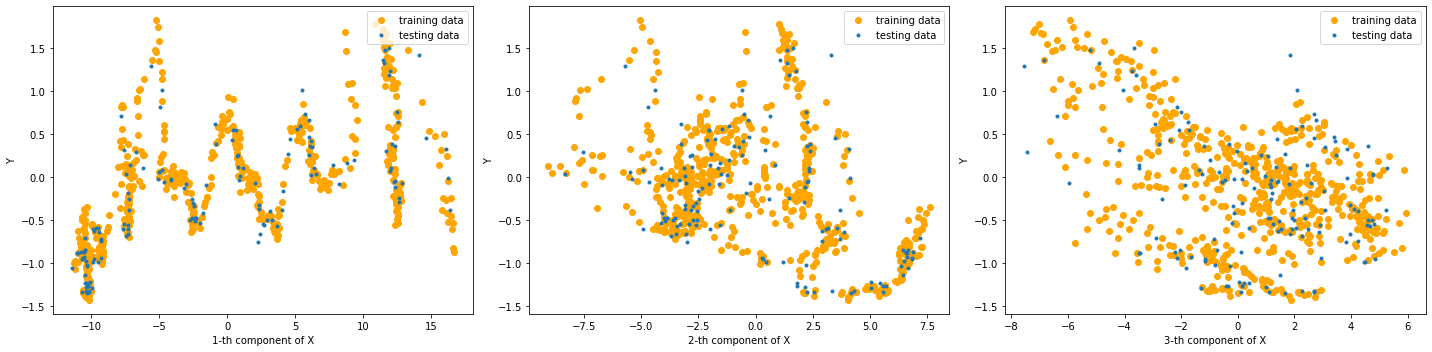

In [10]:
# read the data
X = pd.read_csv('X_pca_top3.CSV')
X = X.to_numpy()[:,1:4]
Y = pd.read_csv('Scaled_values_of_Y.CSV')
Y = Y.to_numpy()[:,1:4]


# We use X to predict Y = UEMP15T26
Y_UEMP = Y[:,0].reshape(-1,1)
# # We use X to predict Y = TB3SMFFM
# Y_TB3 = Y[:,1].reshape(-1,1)
# # We use X to predict Y = TB6SMFFM
# Y_TB6 = Y[:,2].reshape(-1,1)

# Remove outliers (w.r.t Y = UEMP15T26) using IQR
Data = np.hstack([X,Y_UEMP])
Q1 = np.percentile(Y_UEMP, 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(Y_UEMP, 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
upper=Q3+1.5*IQR
upper_array=np.array(Y_UEMP<=upper)
lower=Q1-1.5*IQR
lower_array=np.array(Y_UEMP>=lower)
index_keep = upper_array & lower_array
Data = Data[index_keep[:,0].tolist(),:]

print("The number of data being removed is ", Y_UEMP.shape[0]-Data.shape[0])


# split the data into training and testing
from sklearn.model_selection import train_test_split
training_data, testing_data = train_test_split(Data, test_size=0.2, random_state=25)

X_train = training_data[:,0:3]
Y_train = training_data[:,3].reshape(-1,1)
X_t = testing_data[:,0:3]
Y_t = testing_data[:,3].reshape(-1,1)


# Plot the data
plt.figure(figsize=(20,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot(X_train[:,i],Y_train,'o',color = 'orange',label = 'training data')
    plt.plot(X_t[:,i],Y_t,'.', label = 'testing data')
    plt.xlabel('%d-th component of X' % (i+1))
    plt.ylabel('Y')
    plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# pre-training data, opt data, adj data
n1 = round(0.8*X_train.shape[0])
#n2 = round(0.9*X_train.shape[0])
X_pre = X_train[0:n1,:]
Y_pre = Y_train[0:n1,:]
X_opt = X_train[n1:,:]
Y_opt = Y_train[n1:,:]
# X_opt = X_train[n1:n2,:]
# Y_opt = Y_train[n1:n2,:]
# X_adj = X_train[n2:,:]
# Y_adj = Y_train[n2:,:]
X_adj = np.zeros((1,3))
Y_adj = np.zeros(1).reshape(-1,1)

n_pre = len(X_pre)
n_opt = len(X_opt)
n_adj = len(X_adj)
n_t = len(X_t)

/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/quantile_forest/_quantile_forest.py:104: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  super(BaseForestQuantileRegressor, self).fit(X, y, sample_weight=sample_weight)
/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


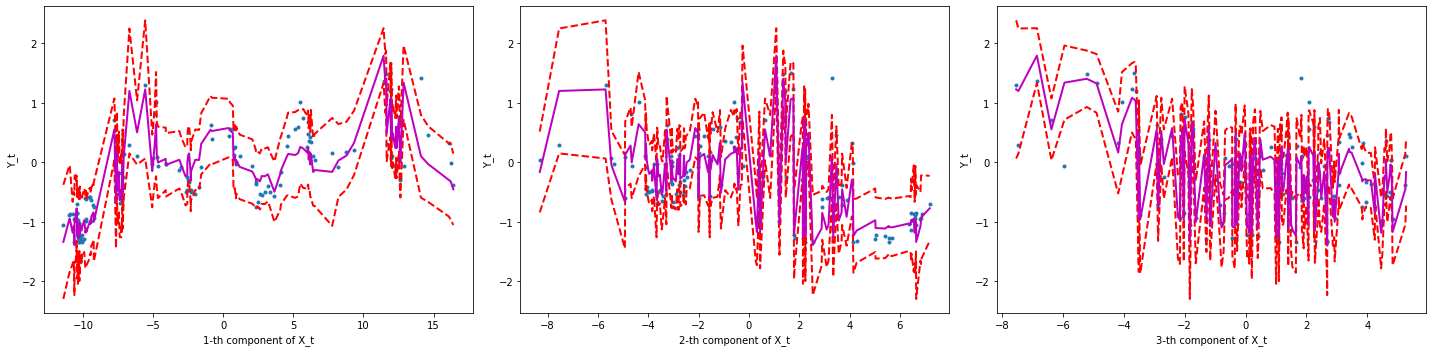

The overall coverage is 0.9517241379310345
The mean bandwidth for testing data is 0.35707043707493635


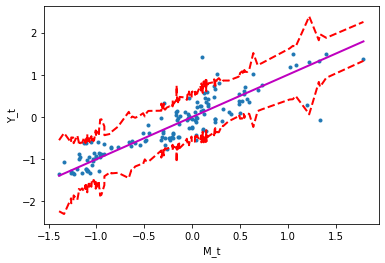

In [11]:
# Obtain mean estimator
known_mean = "False"
if known_mean == "True":
    M_opt = np.zeros(n_opt).reshape(-1,1)
    M_adj = np.zeros(n_adj).reshape(-1,1)
    M_t = np.zeros(n_t).reshape(-1,1)
else:
    est_type = "poly3"
    mdoel, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)
    
# Obtain quantile estimators
quantile = [0.8,0.85,0.9,0.95]
m1,Q1_opt,Q1_adj,Q1_t = est_quantile("NN1",quantile[0],X_pre,Y_pre,X_opt,X_adj,X_t)
m2,Q2_opt,Q2_adj,Q2_t = est_quantile("NN2",quantile[1],X_pre,Y_pre,X_opt,X_adj,X_t)
m3,Q3_opt,Q3_adj,Q3_t = est_quantile("qrf",quantile[2],X_pre,Y_pre,X_opt,X_adj,X_t)
m4,Q4_opt,Q4_adj,Q4_t = est_quantile("gb",quantile[3],X_pre,Y_pre,X_opt,X_adj,X_t)

# construct estimator matrix
E_opt = np.hstack(((Q1_opt-M_opt)**2, (Q2_opt-M_opt)**2, (Q3_opt-M_opt)**2, (Q4_opt-M_opt)**2))
E_opt = E_opt.T
E_adj = np.hstack(((Q1_adj-M_adj)**2, (Q2_adj-M_adj)**2, (Q3_adj-M_adj)**2, (Q4_adj-M_adj)**2))
E_adj = E_adj.T
E_t = np.hstack(((Q1_t-M_t)**2, (Q2_t-M_t)**2, (Q3_t-M_t)**2, (Q4_t-M_t)**2))
E_t = E_t.T

# solve optimization problem

V100_adj, V100_t, opt_sol = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "aug", E_opt, E_adj, E_t)
#V100_adj, V100_t, opt_sol = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_poly", degree = 2)
#V100_adj, V100_t, opt_sol = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_rbf", sigma = 1)

# # adjust interval
# alpha = 0.05
# delta = interval_adj(X_adj,Y_adj,M_adj,V100_adj,alpha)

# plot
# V_alpha_t = delta*V100_t
my_plot(X_t,Y_t,M_t,V100_t)
my_plot2(X_t,Y_t,M_t,V100_t)